# Assignment 3 - Reinforcement Learning with Deep Q-Networks

#### Kobee Raveendran
#### CAP 5610

### Imports (Gym environment and Deep Q-Network dependencies)

In [15]:
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
import matplotlib.pyplot as plt
%matplotlib notebook

plt.style.use('seaborn-whitegrid')

### Agent and Environment (Explanation)

#### Agent
The agent in the CartPole environment is simply the cart itself; it is responsible for doing the "learning" in this problem. The agent interacts with the environment and learns optimal actions that correspond to higher rewards through experience over time. It gets a sense for which actions are optimal by first performing the action, then receiving a reward from the observation of the next state given by the environment (which repeats in a cyclic fashion).

#### Agent Action Space
In this environment, there is a defined action space that represents the set of actions an agent can perform at each time step. In the CartPole environment, the cart (agent) can only perform one of two actions: move left or right. These two actions constitute the action space, and can be confirmed by viewing the elements or size of the action space (as in `env.action_space.n`).

#### Observation Space
Since this is a relatively simple environment, the observation space, which is the simplest representation for the current state of the environment at each time step, is fairly small. It consists of only 4 elements (confirmed by viewing the shape of `env.observation_space`), which are the **cart position**, **cart velocity**, **pole angle**, and **velocity of the pole at the tip** (confirmed by the cartpole environment source code).

#### Rewards
In the CartPole environment, rewards are fairly straightforward. For every time step that the pole is aloft and in a "surviving" (non-terminal) state, the agent receives a reward of +1. A state is deemed terminal if the pole's angle surpasses a set threshold (+/- 12 degrees) or if the cart has passed a certain distance away from the center (2.4 units), thus reaching the edge of the display (according to the CartPole source code).

In [31]:
def cartpole():
    
    # set the default parameters (of which only one will vary per function call)
    params = {
        'learning_rate': 0.001, 
        'gamma': 0.95, 
        'epsilon': 1.0, 
        'epsilon_min': 0.01, 
        'epsilon_decay': 0.995
    }
    
    env = gym.make('CartPole-v0')
        
    obs_space = env.observation_space.shape[0]
    action_space = env.action_space.n    
        
    dqn = DQN(
        obs_space, 
        action_space, 
        params['learning_rate'], 
        params['gamma'], 
        params['epsilon'], 
        params['epsilon_min'], 
        params['epsilon_decay']
    )
        
    scores = []
        
    # raise the cap for max. number of time steps per episode
    # (cartpole v0 uses a default of 200, which would cap the reward
    # of the agent at 200 even though it could achieve higher scores)
    env._max_episode_steps = 1000
        
    for episode in range(100):
        state = env.reset()
        state = np.reshape(state, [1, obs_space])

        time_step = 0
        done = False

        while not done:

            action = dqn.act(state)

            observation, reward, done, info = env.step(action)
            observation = np.reshape(observation, [1, obs_space])
                
            dqn.remember(state, action, reward, observation, done)
                
            state = observation
                
            time_step += 1

            if done and (episode + 1) % 25 == 0:
                print('Episode: {} of {}; score: {}'.format(episode + 1, 100, time_step))
                break

            dqn.experience_replay(32)

        scores.append(time_step)

    mean_survival_time = np.mean(scores)
    fit_line = np.polyfit(x = range(len(scores)), y = scores, deg = 1)
    fit = np.poly1d(fit_line)
    
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(range(len(scores)), fit(range(len(scores))))
    print('Mean survival time: ', mean_survival_time)
    
    env.close()

#### Set up neural network architecture

Episode: 25 of 100; score: 27
Episode: 50 of 100; score: 11
Episode: 75 of 100; score: 339
Episode: 100 of 100; score: 661


<IPython.core.display.Javascript object>


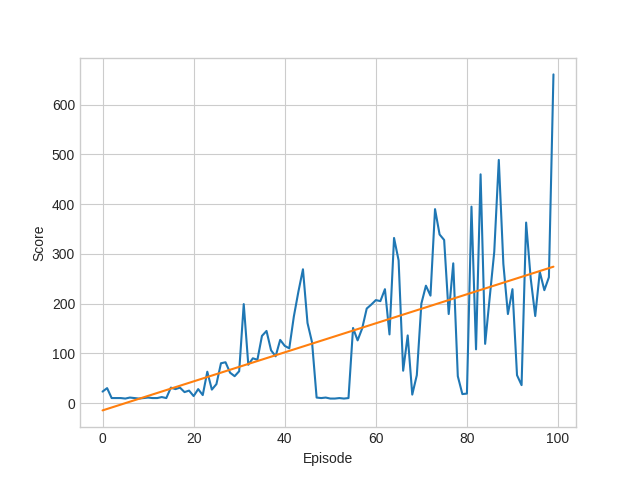

Mean survival time:  129.71


In [32]:
class DQN:
    
    def __init__(self, 
                 obs_space, 
                 action_space, 
                 learning_rate = 0.001, 
                 gamma = 0.95, 
                 epsilon = 1.0, 
                 epsilon_min = 0.01,
                 epsilon_decay = 0.995
                ):
        self.action_space = action_space
        
        self.memory = deque(maxlen = 2000)
        self.learning_rate = learning_rate
        self.gamma = gamma                       # 'discount' rate
        self.epsilon = epsilon                   # exploration rate
        self.epsilon_min = epsilon_min           # min exploration rate
        self.epsilon_decay = epsilon_decay       # exploration rate decay
        
        self.model = Sequential()
        
        self.model.add(Dense(24, input_dim = obs_space, activation = 'relu'))
        self.model.add(Dense(24, activation = 'relu'))
        self.model.add(Dense(self.action_space, activation = 'linear'))
        
        self.model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        
        q_vals = self.model.predict(state)
        
        return np.argmax(q_vals[0])
        
    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        batch = random.sample(self.memory, batch_size)
        
        for state, action, reward, state_next, done in batch:
            q_update = reward
            
            if not done:
                q_update = reward + self.gamma * np.amax(self.model.predict(state_next)[0])
                
            q_values = self.model.predict(state)
            
            q_values[0][action] = q_update
            
            self.model.fit(state, q_values, epochs = 1, verbose = 0)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            

# test param configurations in standalone runs (some configs will be duplicated as they match the default vals)
cartpole()
#cartpole('learning_rate', [0.001])  0.01, 0.1, 1.0, 10.0
#cartpole('gamma', [0.25, 0.5, 0.75, 0.95])
#cartpole('epsilon', [1.0, 1.5, 10.0])
#cartpole('epsilon_min', [0.001, 0.01, 0.1, 1.0])
#cartpole('epsilon_decay', [0.75, 0.9, 0.995, 1.0])